In [1]:
import scipy.io as io
import numpy as np

y=io.loadmat("D:\\机器学习前沿实验\\实验课一\\dataset\\PPMI.mat")

# 为数组打上标签 
#NC=0
#PD=1

In [2]:
NC=np.asarray(y['NC'])
NC_lable=np.full((NC.shape[0],1),0,dtype=int)

In [3]:
NC.shape

(169, 294)

In [4]:
PD=np.asarray(y['PD'])
PD_lable=np.full((PD.shape[0],1),1,dtype=int)

In [5]:
PD.shape

(374, 294)

In [6]:
print(NC_lable.shape)
print(PD_lable.shape)

(169, 1)
(374, 1)


# 数据已经是二维，可以直接使用，无需转换

In [7]:
Label=np.vstack((NC_lable,PD_lable))
Data=np.vstack((NC,PD))


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
print(split )       # doctest: +ELLIPSIS
 
# StratifiedShuffleSplit(n_splits=3, random_state=0, ...)
for train_index, test_index in split.split(Data,Label):
    print('数据划分完成')
    #可以选择打印划分情况--对应index
    #print("TRAIN:", train_index, "TEST:", test_index)
Train, Test = Data[train_index], Data[test_index]
label_train,label_test=Label[train_index], Label[test_index]
 
"""
StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5,train_size=None)
"""

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
数据划分完成


'\nStratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5,train_size=None)\n'

In [9]:
from sklearn import ensemble
model=ensemble.GradientBoostingClassifier()

model.fit(Train,label_train)
pred = model.predict(Test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_test, pred)
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

D:\kobe\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7064220183486238


In [10]:
from tensorflow.keras.utils import to_categorical
Label=to_categorical(Label)

Label.shape

(543, 2)

# 将数据合并

# 可以通过test_size来确定数据划分情况！ 

In [11]:
import time
import warnings
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import newaxis
import pandas as pd
from keras.models import Sequential
from keras.layers import Bidirectional,LSTM,BatchNormalization
from keras.layers.core import Dense, Activation, Dropout
import keras.layers as layers
from keras.models import Sequential

In [12]:
import keras.backend as K
from keras.callbacks import LearningRateScheduler
 
def scheduler(epoch):
    if epoch  == 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*10)
    # 每隔5个epoch，学习率减小为原来的1/10
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr*10)
        K.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model.optimizer.lr)
 
reduce_lr = LearningRateScheduler(scheduler)

In [13]:
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer = 'rmsprop',                 # 加速神经网络
        loss = 'categorical_crossentropy',   # 损失函数
        metrics = ['accuracy'], )
    return model

In [14]:
    model = Sequential()
    model.add(layers.Convolution1D(128,3,strides=1))
    model.add(layers.LayerNormalization())
    model.add(Activation('relu'))
    model.add(layers.Convolution1D(256,3,strides=1))
    model.add(layers.LayerNormalization())
    model.add(Activation('relu'))
    model.add(layers.Convolution1D(128,3,strides=1))
    model.add(layers.LayerNormalization())
    model.add(Activation('relu'))
    model.add(layers.GlobalAveragePooling1D())
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    model.build(input_shape=(None,None,294))
    model.summary()
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         113024    
                                                                 
 layer_normalization (LayerN  (None, None, 128)        256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 256)         98560     
                                                                 
 layer_normalization_1 (Laye  (None, None, 256)        512       
 rNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, None, 256)         0

In [15]:
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn import metrics

kf = KFold(n_splits=5, shuffle=True,random_state=42) # 5折交叉验证

i = 1
a=[]
h=np.asarray(Data)
Label=np.asarray(Label)
for train_index, test_index in kf.split(h, Label):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    X_train, X_test = h[train_index], h[test_index] 
    y_train, y_test = Label[train_index], Label[test_index]
    model=build_model()
    history=model.fit(X_train,y_train,batch_size=5,epochs=100,validation_data=(X_test,y_test),callbacks=[reduce_lr])
    x=np.asarray(history.history['accuracy']), 
    y=np.asarray(history.history['val_accuracy'])
    b=np.asarray(y)
    a.append(b.max())
    i += 1


1 of kfold 5
Epoch 1/100
87/87 [==============================] - 17s 49ms/step - loss: 0.8938 - accuracy: 0.5945 - val_loss: 8.5099 - val_accuracy: 0.6239 - lr: 0.0100
Epoch 2/100
87/87 [==============================] - 2s 18ms/step - loss: 0.7220 - accuracy: 0.6221 - val_loss: 1.2928 - val_accuracy: 0.6055 - lr: 0.0100
Epoch 3/100
87/87 [==============================] - 2s 18ms/step - loss: 0.6625 - accuracy: 0.6820 - val_loss: 2.1038 - val_accuracy: 0.6239 - lr: 0.0100
Epoch 4/100
87/87 [==============================] - 2s 19ms/step - loss: 0.6447 - accuracy: 0.6751 - val_loss: 1.0792 - val_accuracy: 0.6239 - lr: 0.0100
Epoch 5/100
87/87 [==============================] - 2s 20ms/step - loss: 0.6486 - accuracy: 0.6613 - val_loss: 1.1512 - val_accuracy: 0.6239 - lr: 0.0100
Epoch 6/100
87/87 [==============================] - 2s 20ms/step - loss: 0.6255 - accuracy: 0.7074 - val_loss: 2.6346 - val_accuracy: 0.6147 - lr: 0.0100
Epoch 7/100
87/87 [==============================] - 2s

87/87 [==============================] - 2s 22ms/step - loss: 0.6068 - accuracy: 0.7028 - val_loss: 7726.3154 - val_accuracy: 0.6239 - lr: 0.0100
Epoch 53/100
87/87 [==============================] - 2s 21ms/step - loss: 0.6155 - accuracy: 0.7051 - val_loss: 3385.2610 - val_accuracy: 0.6239 - lr: 0.0100
Epoch 54/100
87/87 [==============================] - 2s 21ms/step - loss: 0.6269 - accuracy: 0.7051 - val_loss: 5885.5825 - val_accuracy: 0.6330 - lr: 0.0100
Epoch 55/100
87/87 [==============================] - 2s 22ms/step - loss: 0.6114 - accuracy: 0.7005 - val_loss: 4832.4780 - val_accuracy: 0.6330 - lr: 0.0100
Epoch 56/100
87/87 [==============================] - 2s 21ms/step - loss: 0.6034 - accuracy: 0.6935 - val_loss: 2419.7629 - val_accuracy: 0.6330 - lr: 0.0100
Epoch 57/100
87/87 [==============================] - 2s 19ms/step - loss: 0.5961 - accuracy: 0.7005 - val_loss: 1956.7386 - val_accuracy: 0.3761 - lr: 0.0100
Epoch 58/100
87/87 [==============================] - 2s 21

87/87 [==============================] - 1s 17ms/step - loss: 0.7107 - accuracy: 0.6267 - val_loss: 15.3595 - val_accuracy: 0.3119 - lr: 0.0100
Epoch 3/100
87/87 [==============================] - 2s 20ms/step - loss: 0.6821 - accuracy: 0.6567 - val_loss: 3.7180 - val_accuracy: 0.2936 - lr: 0.0100
Epoch 4/100
87/87 [==============================] - 2s 22ms/step - loss: 0.6610 - accuracy: 0.6636 - val_loss: 0.8953 - val_accuracy: 0.6147 - lr: 0.0100
Epoch 5/100
87/87 [==============================] - 2s 22ms/step - loss: 0.6190 - accuracy: 0.6659 - val_loss: 0.9064 - val_accuracy: 0.6881 - lr: 0.0100
Epoch 6/100
87/87 [==============================] - 2s 22ms/step - loss: 0.6299 - accuracy: 0.6544 - val_loss: 0.6854 - val_accuracy: 0.6972 - lr: 0.0100
Epoch 7/100
87/87 [==============================] - 2s 22ms/step - loss: 0.6387 - accuracy: 0.6659 - val_loss: 1.2446 - val_accuracy: 0.6514 - lr: 0.0100
Epoch 8/100
87/87 [==============================] - 2s 23ms/step - loss: 0.6235 

Epoch 53/100
87/87 [==============================] - 2s 21ms/step - loss: 0.5711 - accuracy: 0.6820 - val_loss: 23742.3145 - val_accuracy: 0.6606 - lr: 0.0100
Epoch 54/100
87/87 [==============================] - 2s 24ms/step - loss: 0.5172 - accuracy: 0.7074 - val_loss: 2011.7731 - val_accuracy: 0.4037 - lr: 0.0100
Epoch 55/100
87/87 [==============================] - 2s 22ms/step - loss: 0.5424 - accuracy: 0.7051 - val_loss: 28000.2852 - val_accuracy: 0.3119 - lr: 0.0100
Epoch 56/100
87/87 [==============================] - 2s 23ms/step - loss: 0.5755 - accuracy: 0.7281 - val_loss: 17757.2910 - val_accuracy: 0.6055 - lr: 0.0100
Epoch 57/100
87/87 [==============================] - 2s 24ms/step - loss: 0.5623 - accuracy: 0.6797 - val_loss: 78711.5859 - val_accuracy: 0.6972 - lr: 0.0100
Epoch 58/100
87/87 [==============================] - 2s 23ms/step - loss: 0.5613 - accuracy: 0.7028 - val_loss: 72528.3125 - val_accuracy: 0.6055 - lr: 0.0100
Epoch 59/100
87/87 [=====================

Epoch 3/100
87/87 [==============================] - 2s 22ms/step - loss: 0.6849 - accuracy: 0.6198 - val_loss: 3.2640 - val_accuracy: 0.3119 - lr: 0.0100
Epoch 4/100
87/87 [==============================] - 2s 24ms/step - loss: 0.6512 - accuracy: 0.6567 - val_loss: 1.7106 - val_accuracy: 0.7156 - lr: 0.0100
Epoch 5/100
87/87 [==============================] - 2s 21ms/step - loss: 0.6526 - accuracy: 0.6567 - val_loss: 1.9513 - val_accuracy: 0.6789 - lr: 0.0100
Epoch 6/100
87/87 [==============================] - 2s 25ms/step - loss: 0.6567 - accuracy: 0.6498 - val_loss: 4.4001 - val_accuracy: 0.6697 - lr: 0.0100
Epoch 7/100
87/87 [==============================] - 2s 25ms/step - loss: 0.6399 - accuracy: 0.6820 - val_loss: 4.2090 - val_accuracy: 0.6881 - lr: 0.0100
Epoch 8/100
87/87 [==============================] - 2s 24ms/step - loss: 0.6256 - accuracy: 0.6797 - val_loss: 0.9511 - val_accuracy: 0.7156 - lr: 0.0100
Epoch 9/100
87/87 [==============================] - 2s 23ms/step - lo

Epoch 54/100
87/87 [==============================] - 1s 8ms/step - loss: 0.5598 - accuracy: 0.7166 - val_loss: 38318.4805 - val_accuracy: 0.6881 - lr: 0.0100
Epoch 55/100
87/87 [==============================] - 1s 8ms/step - loss: 0.5860 - accuracy: 0.6797 - val_loss: 39538.6211 - val_accuracy: 0.7248 - lr: 0.0100
Epoch 56/100
87/87 [==============================] - 1s 7ms/step - loss: 0.6290 - accuracy: 0.6705 - val_loss: 599753.8750 - val_accuracy: 0.2661 - lr: 0.0100
Epoch 57/100
87/87 [==============================] - 1s 7ms/step - loss: 0.6178 - accuracy: 0.6705 - val_loss: 613477.5625 - val_accuracy: 0.2752 - lr: 0.0100
Epoch 58/100
87/87 [==============================] - 1s 7ms/step - loss: 0.6201 - accuracy: 0.6912 - val_loss: 33270.0000 - val_accuracy: 0.7064 - lr: 0.0100
Epoch 59/100
87/87 [==============================] - 1s 6ms/step - loss: 0.6305 - accuracy: 0.6705 - val_loss: 364858.4375 - val_accuracy: 0.7156 - lr: 0.0100
Epoch 60/100
87/87 [=======================

87/87 [==============================] - 0s 6ms/step - loss: 0.6589 - accuracy: 0.6575 - val_loss: 3.3112 - val_accuracy: 0.4259 - lr: 0.0100
Epoch 5/100
87/87 [==============================] - 1s 7ms/step - loss: 0.6414 - accuracy: 0.6598 - val_loss: 1.4303 - val_accuracy: 0.6204 - lr: 0.0100
Epoch 6/100
87/87 [==============================] - 1s 8ms/step - loss: 0.6345 - accuracy: 0.6621 - val_loss: 5.6571 - val_accuracy: 0.4259 - lr: 0.0100
Epoch 7/100
87/87 [==============================] - 1s 7ms/step - loss: 0.6283 - accuracy: 0.6736 - val_loss: 8.3453 - val_accuracy: 0.5185 - lr: 0.0100
Epoch 8/100
87/87 [==============================] - 1s 8ms/step - loss: 0.6294 - accuracy: 0.6713 - val_loss: 3.7878 - val_accuracy: 0.6759 - lr: 0.0100
Epoch 9/100
87/87 [==============================] - 1s 7ms/step - loss: 0.6250 - accuracy: 0.6759 - val_loss: 30.2416 - val_accuracy: 0.6389 - lr: 0.0100
Epoch 10/100
87/87 [==============================] - 1s 7ms/step - loss: 0.6243 - accu

Epoch 55/100
87/87 [==============================] - 0s 5ms/step - loss: 0.5739 - accuracy: 0.7103 - val_loss: 1902135.3750 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 56/100
87/87 [==============================] - 1s 7ms/step - loss: 0.5647 - accuracy: 0.7103 - val_loss: 4960666.0000 - val_accuracy: 0.5463 - lr: 0.0100
Epoch 57/100
87/87 [==============================] - 0s 5ms/step - loss: 0.5635 - accuracy: 0.7172 - val_loss: 976026.8125 - val_accuracy: 0.6111 - lr: 0.0100
Epoch 58/100
87/87 [==============================] - 0s 6ms/step - loss: 0.5805 - accuracy: 0.6989 - val_loss: 1620418.3750 - val_accuracy: 0.4630 - lr: 0.0100
Epoch 59/100
87/87 [==============================] - 0s 6ms/step - loss: 0.5680 - accuracy: 0.7080 - val_loss: 436896.0312 - val_accuracy: 0.6481 - lr: 0.0100
Epoch 60/100
87/87 [==============================] - 0s 5ms/step - loss: 0.6214 - accuracy: 0.7057 - val_loss: 4618106.0000 - val_accuracy: 0.3333 - lr: 0.0100
lr changed to 0.010000000894069673
E

87/87 [==============================] - 0s 5ms/step - loss: 0.6571 - accuracy: 0.6322 - val_loss: 0.6305 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 6/100
87/87 [==============================] - 1s 6ms/step - loss: 0.6606 - accuracy: 0.6391 - val_loss: 1.1351 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 7/100
87/87 [==============================] - 0s 5ms/step - loss: 0.6546 - accuracy: 0.6483 - val_loss: 0.5897 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 8/100
87/87 [==============================] - 1s 6ms/step - loss: 0.6529 - accuracy: 0.6598 - val_loss: 0.6381 - val_accuracy: 0.7407 - lr: 0.0100
Epoch 9/100
87/87 [==============================] - 0s 6ms/step - loss: 0.6401 - accuracy: 0.6621 - val_loss: 1.8256 - val_accuracy: 0.2870 - lr: 0.0100
Epoch 10/100
87/87 [==============================] - 0s 6ms/step - loss: 0.6299 - accuracy: 0.6690 - val_loss: 0.9839 - val_accuracy: 0.3333 - lr: 0.0100
lr changed to 0.010000000894069673
Epoch 11/100
87/87 [==============================] 

87/87 [==============================] - 0s 5ms/step - loss: 0.5868 - accuracy: 0.6713 - val_loss: 4519.5776 - val_accuracy: 0.3426 - lr: 0.0100
Epoch 57/100
87/87 [==============================] - 0s 5ms/step - loss: 0.5815 - accuracy: 0.6966 - val_loss: 9.1783 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 58/100
87/87 [==============================] - 1s 6ms/step - loss: 0.5906 - accuracy: 0.6782 - val_loss: 1404081.5000 - val_accuracy: 0.3704 - lr: 0.0100
Epoch 59/100
87/87 [==============================] - 0s 5ms/step - loss: 0.5605 - accuracy: 0.7149 - val_loss: 2406.4075 - val_accuracy: 0.7407 - lr: 0.0100
Epoch 60/100
87/87 [==============================] - 0s 6ms/step - loss: 0.5729 - accuracy: 0.6851 - val_loss: 504735.3438 - val_accuracy: 0.6389 - lr: 0.0100
lr changed to 0.010000000894069673
Epoch 61/100
87/87 [==============================] - 0s 6ms/step - loss: 0.5919 - accuracy: 0.6989 - val_loss: 525838.1250 - val_accuracy: 0.7222 - lr: 0.0100
Epoch 62/100
87/87 [======

In [16]:
a=np.asarray(a)
print(a.mean())

0.7164118170738221


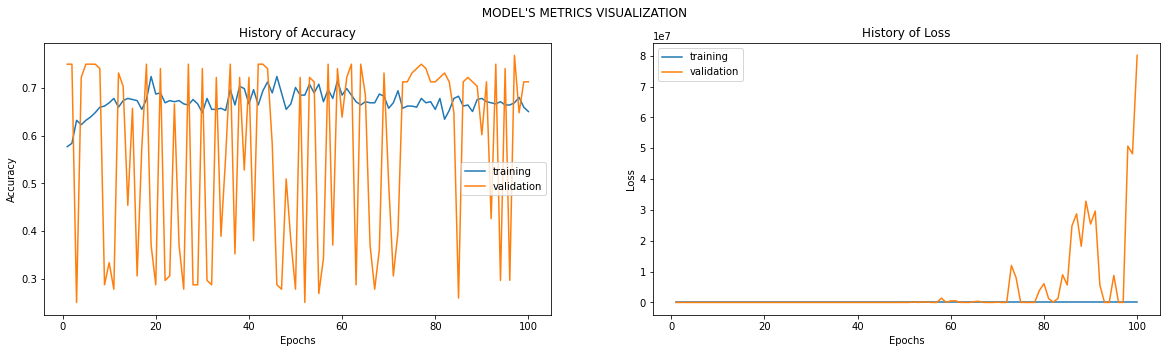

In [17]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    


    plt.show()
    
import matplotlib.pyplot as plt
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
              )

In [83]:
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression

kf = KFold(n_splits=5, shuffle=True,random_state=42) # 5折交叉验证

i = 1
a=[]
h=np.asarray(Data)
Label=np.asarray(Label)
for train_index, test_index in kf.split(h, Label):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    X_train, X_test = h[train_index], h[test_index] 
    y_train, y_test = Label[train_index], Label[test_index]
#     from sklearn import ensemble
#     model=ensemble.ExtraTreesClassifier()#yeah!
#     model=ensemble.RandomForestClassifier()
    from sklearn import svm
    model=svm.SVC()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, pred)
    accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
    print(accuracy)
#     print(cm)
    a.append(accuracy)
    i += 1
b=np.asarray(a)
print(b.mean())


1 of kfold 5
0.6238532110091743

2 of kfold 5
0.6880733944954128

3 of kfold 5
0.7155963302752294

4 of kfold 5
0.6666666666666666

5 of kfold 5
0.75
0.6888379204892966


D:\kobe\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\kobe\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\kobe\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\kobe\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\k

C:\Users\BRYANT~1\AppData\Local\Temp/ipykernel_20516/3194784478.py:60: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
C:\Users\BRYANT~1\AppData\Local\Temp/ipykernel_20516/3194784478.py:72: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))


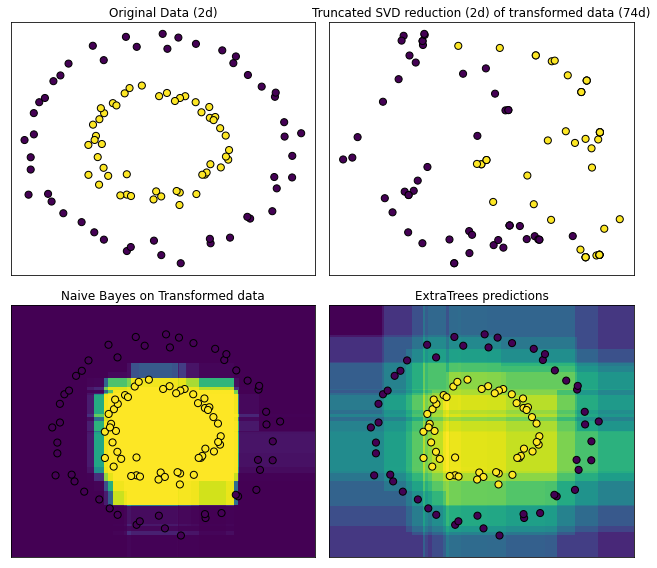

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB

# make a synthetic dataset
X, y = make_circles(factor=0.5, random_state=0, noise=0.05)

# use RandomTreesEmbedding to transform data
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)

# Visualize result after dimensionality reduction using truncated SVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)

# Learn a Naive Bayes classifier on the transformed data
nb = BernoulliNB()
nb.fit(X_transformed, y)


# Learn an ExtraTreesClassifier for comparison
trees = ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)
trees.fit(X, y)


# scatter plot of original and reduced data
fig = plt.figure(figsize=(9, 8))

ax = plt.subplot(221)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor="k")
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(222)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50, edgecolor="k")
ax.set_title(
    "Truncated SVD reduction (2d) of transformed data (%dd)" % X_transformed.shape[1]
)
ax.set_xticks(())
ax.set_yticks(())

# Plot the decision in original space. For that, we will assign a color
# to each point in the mesh [x_min, x_max]x[y_min, y_max].
h = 0.01
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# transform grid using RandomTreesEmbedding
transformed_grid = hasher.transform(np.c_[xx.ravel(), yy.ravel()])
y_grid_pred = nb.predict_proba(transformed_grid)[:, 1]

ax = plt.subplot(223)
ax.set_title("Naive Bayes on Transformed data")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor="k")
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

# transform grid using ExtraTreesClassifier
y_grid_pred = trees.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

ax = plt.subplot(224)
ax.set_title("ExtraTrees predictions")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor="k")
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
plt.show()